# Multiple networks

This example demonstrates the use of multiple networks in a single script and the use of `parallel_run()`:

ANNarchy 4.6 (4.6.0b) on linux (posix). 
Running 2 networks sequentially took: 0.3284029960632324 
Running 2 networks in parallel took: 0.20238137245178223 
Running 4 networks in parallel took: 0.9471218585968018 


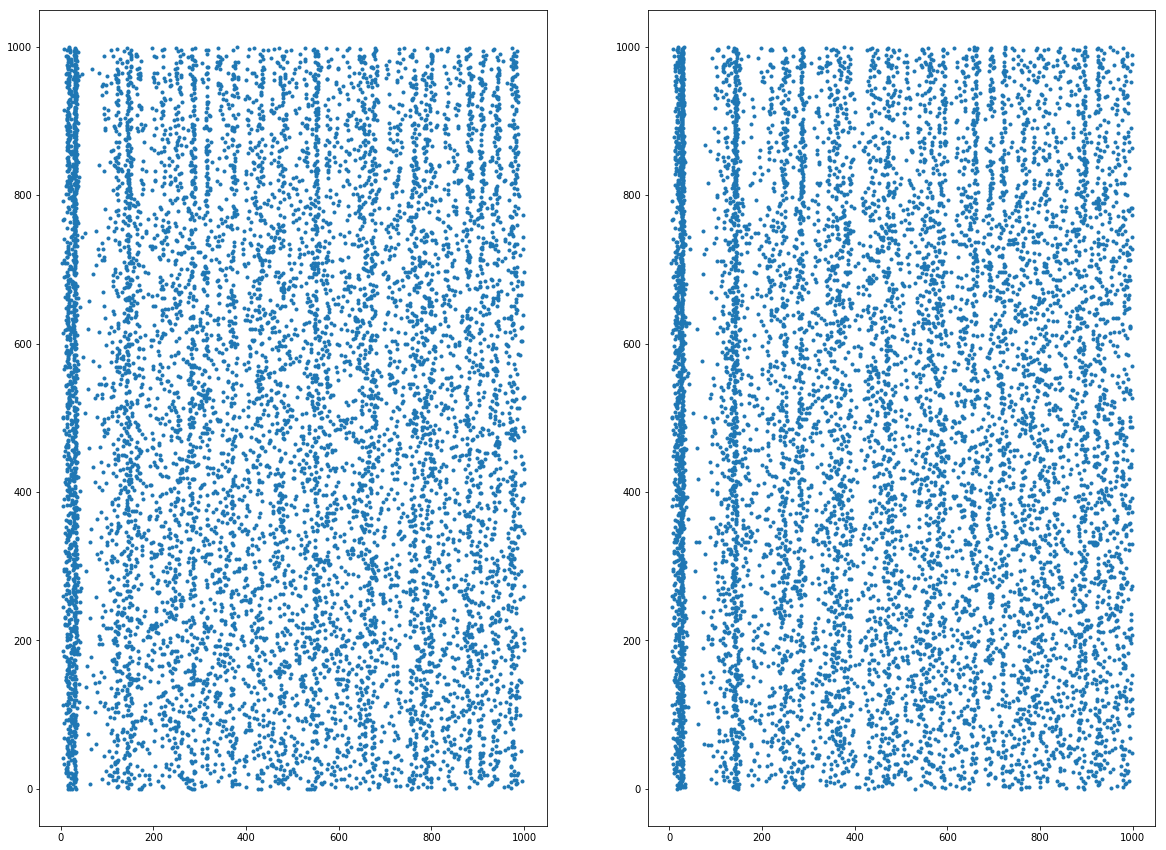

In [1]:
from ANNarchy import *
clear()

# Create the whole population
P = Population(geometry=1000, neuron=Izhikevich)

# Create the excitatory population
Exc = P[:800]
re = np.random.random(800)
Exc.noise = 5.0
Exc.a = 0.02
Exc.b = 0.2
Exc.c = -65.0 + 15.0 * re**2
Exc.d = 8.0 - 6.0 * re**2
Exc.v = -65.0
Exc.u = Exc.v * Exc.b

# Create the Inh population
Inh = P[800:]
ri = np.random.random(200)
Inh.noise = 2.0
Inh.a = 0.02 + 0.08 * ri
Inh.b = 0.25 - 0.05 * ri
Inh.c = -65.0
Inh.d = 2.0
Inh.v = -65.0
Inh.u = Inh.v * Inh.b

# Create the projections
proj_exc = Projection(Exc, P, 'exc')
proj_inh = Projection(Inh, P, 'inh')

proj_exc.connect_all_to_all(weights=Uniform(0.0, 0.5))
proj_inh.connect_all_to_all(weights=Uniform(0.0, 1.0))

# Create a spike monitor
M = Monitor(P, 'spike')

compile()

# Create a network with specified populations and projections
net = Network()
net.add(P)
net.add([proj_exc, proj_inh])
net.add(M)
net.compile()

# Create a network based on everything created until now (equivalent)
net2 = Network(everything=True)
net2.compile()

# Method to be applied on each network
def run_network(idx, net):
    # Retrieve subpopulations
    P_local = net.get(P)
    Exc = P_local[:800]
    Inh = P_local[800:]
    # Randomize initialization
    re = np.random.random(800)
    Exc.c = -65.0 + 15.0 * re**2
    Exc.d = 8.0 - 6.0 * re**2
    ri = np.random.random(200)
    Inh.noise = 2.0
    Inh.a = 0.02 + 0.08 * ri
    Inh.b = 0.25 - 0.05 * ri
    Inh.u = Inh.v * Inh.b
    # Simulate
    net.simulate(1000.)
    # Recordings
    t, n = net.get(M).raster_plot()
    return t, n

# Simulating using the created networks
vals = parallel_run(method=run_network, networks=[net, net2], measure_time=True, sequential=True)
vals = parallel_run(method=run_network, networks=[net, net2], measure_time=True)

# Using just a number of networks to create
vals = parallel_run(method=run_network, number=4, measure_time=True)

# Data analysis
t, n = vals[0]
t2, n2 = vals[1]

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

plt.subplot(121)
plt.plot(t, n, '.')
plt.subplot(122)
plt.plot(t2, n2, '.')
plt.show()